## Exploring and visualizing fire weather index in New Zealand

#### Imports

In [1]:
# Imports
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import pandas as pd
import cartopy.crs as ccrs
import salem
from tqdm import tqdm
from sklearn import preprocessing
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import matplotlib
import glob

In [2]:
# More imports
import pickle
import gc
import rioxarray
from shapely.geometry import mapping
from shapely import wkt
from dateutil.relativedelta import relativedelta
import geopandas
import shapely

#### FWI data handling

In [3]:
# Globals
CHUNKS = {'time':24, 'height':1}
PATH = "/mnt/data/MetService_WRF/"
FWI_PATH = "/mnt/data/FWI_WRF/"

In [4]:
# File handling
def open_dataset(filepath, variable, chunks, years):
    files = [sorted(glob.glob(f'{filepath}{variable}_{year}*', recursive=False)) for year in years]
    # flatten the lists
    files = [item for sublist in files for item in sublist]
    ds =  xr.open_mfdataset(files, chunks=chunks, parallel=True)
    return ds

In [40]:
# Load 5 years FWI
years = list(range(2015, 2021))
ds = open_dataset(FWI_PATH, 'FWI', CHUNKS, years)
ds

<xarray.Dataset>
Dimensions:  (time: 2193, lat: 508, lon: 472)
Coordinates:
  * time     (time) datetime64[ns] 2014-12-31 2015-01-01 ... 2020-12-31
  * lat      (lat) float64 -48.0 -47.97 -47.94 -47.92 ... -34.06 -34.03 -34.01
  * lon      (lon) float64 166.0 166.0 166.1 166.1 ... 178.9 178.9 179.0 179.0
Data variables:
    FFMC     (time, lat, lon) float64 dask.array<chunksize=(24, 508, 472), meta=np.ndarray>
    DMC      (time, lat, lon) float64 dask.array<chunksize=(24, 508, 472), meta=np.ndarray>
    DC       (time, lat, lon) float64 dask.array<chunksize=(24, 508, 472), meta=np.ndarray>
    ISI      (time, lat, lon) float64 dask.array<chunksize=(24, 508, 472), meta=np.ndarray>
    BUI      (time, lat, lon) float64 dask.array<chunksize=(24, 508, 472), meta=np.ndarray>
    FWI      (time, lat, lon) float64 dask.array<chunksize=(24, 508, 472), meta=np.ndarray>

#### Helper functions

In [5]:
# Save and load SOM and predictions so we don't have to run it again 

def som_to_pickle(filename, som):
    """ Pickle the som object in case I want to reopen it later
    """
    with open(filename + ".pkl", 'wb') as file:
        pickle.dump(som, file)
        
        
def open_som_pickle(filename):
    return pickle.load(open(filename, 'rb'))

def preds_to_file(filename, data):
    np.save(filename, data)
    

def load_preds(filename):
    return np.load(filename)

In [6]:
def calc_som(m,n, data, lr=0.5, epochs=10):
    """ Calculate Self Organizing Map
        Fit and predict
    """
    lat_dim = data.shape[1]
    lon_dim = data.shape[2]
    # Build a m x n SOM 
    som = SOM(m=m, n=n, dim=lat_dim*lon_dim, lr=lr)

    # Fit it to the data
    som.fit(data.reshape((data.shape[0],lat_dim*lon_dim)), epochs =epochs)

    # Assign each datapoint to its predicted cluster
    predictions = som.predict(data.reshape((data.shape[0],lat_dim*lon_dim)))
    return som, predictions

In [7]:
def fwi_to_np(ds):
    """ Convert ds.FWI into numpy array without nan
        Works better as a function to garbage collect ds_np
    """
    FWI = ds.FWI
    ds_np=xr.DataArray.to_numpy(FWI.load())
    ds_np_nonan = np.nan_to_num(ds_np, nan = -9999)
    return FWI, ds_np_nonan

def create_som_dict(FWI, predict_som):
    """ Build dictionary splitting the dataset into the predictions
    """
    som_dict = {}
    for i in range(0,9):
        mask = predict_som == i
        som_FWI = FWI[mask]
        mean_FWI = som_FWI.mean(dim="time")
        som_dict[str(i)]=mean_FWI.load()
    return som_dict

def map_som(FWI, som_dict):
    """ Build salem map from FWI data and som predictions
    """
    proj = FWI.salem.cartopy()
    color_map ="Reds"
    color_map ="gist_ncar"

    fig = plt.figure(figsize=[16,12])
    for i in range(0,9):
        ax = plt.subplot(3,3,i+1,projection=proj)
    #     som_dict[str(i)].plot(cmap=color_map, transform=proj, vmin=0, vmax=80, extend="both")
        som_dict[str(i)].plot(cmap=color_map, transform=proj, vmin=2, vmax=30, extend="both")


        ax.coastlines('10m', linewidth=1)
        ax.set_aspect('auto')
        ax.set_extent(FWI.salem.grid.extent, crs=proj)
        ax.gridlines(alpha=0.7)
        plt.tight_layout()


In [8]:
def map_from_pickled_som(somname, predsname):
    """ Rerun mapping on a pickled som
    """
    years = list(range(2015, 2021))
    ds = open_dataset(FWI_PATH, 'FWI', CHUNKS, years)
    predict_som = load_preds(predsname + '.npy')
    som = open_som_pickle(somname + '.pkl')
    FWI = ds.FWI
    som_dict = create_som_dict(FWI, predict_som)
    map_som(FWI, som_dict)

In [9]:
def mask_terrestrial_area(data):
    """ Create a mask of land based on soil moisture
    """
    smois_file = '/mnt/data/MetService_WRF/SMOIS_20000101000000.nc'
    chunks={"height":1,"time":100}
    smois = xr.open_dataset(smois_file,chunks=chunks)
    mask=(smois.SMOIS[0,1,...]<0.9)
    masked_data=data.where(mask)
    return masked_data

In [9]:
%%time    # 
FWI, ds_np_nonan = fwi_to_np(ds)
som, predict_som = calc_som(3,3, ds_np_nonan)

CPU times: user 8min 39s, sys: 2min 16s, total: 10min 55s
Wall time: 10min 58s


saved pickle
saved preds


(array([  13., 1381.,  746.,    8.,    0.,    5.,   11.,    4.,   15.,
          10.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

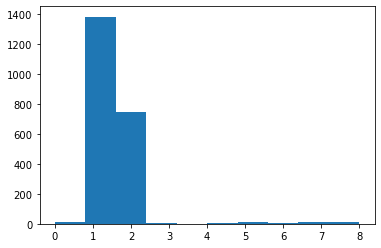

In [14]:
# Save SOM's as we go in case of kernel crash
som_to_pickle('1_som_new', som)
print('saved pickle')
preds_to_file('1_preds_new.npy', predict_som)
print('saved preds')
plt.hist(predict_som)

2 very full clusters.  
Mapping this version:

In [8]:
FWI = ds.FWI
time = ds.time
predict_som = load_preds('1_preds_new.npy')
som = open_som_pickle('1_som_new.pkl')

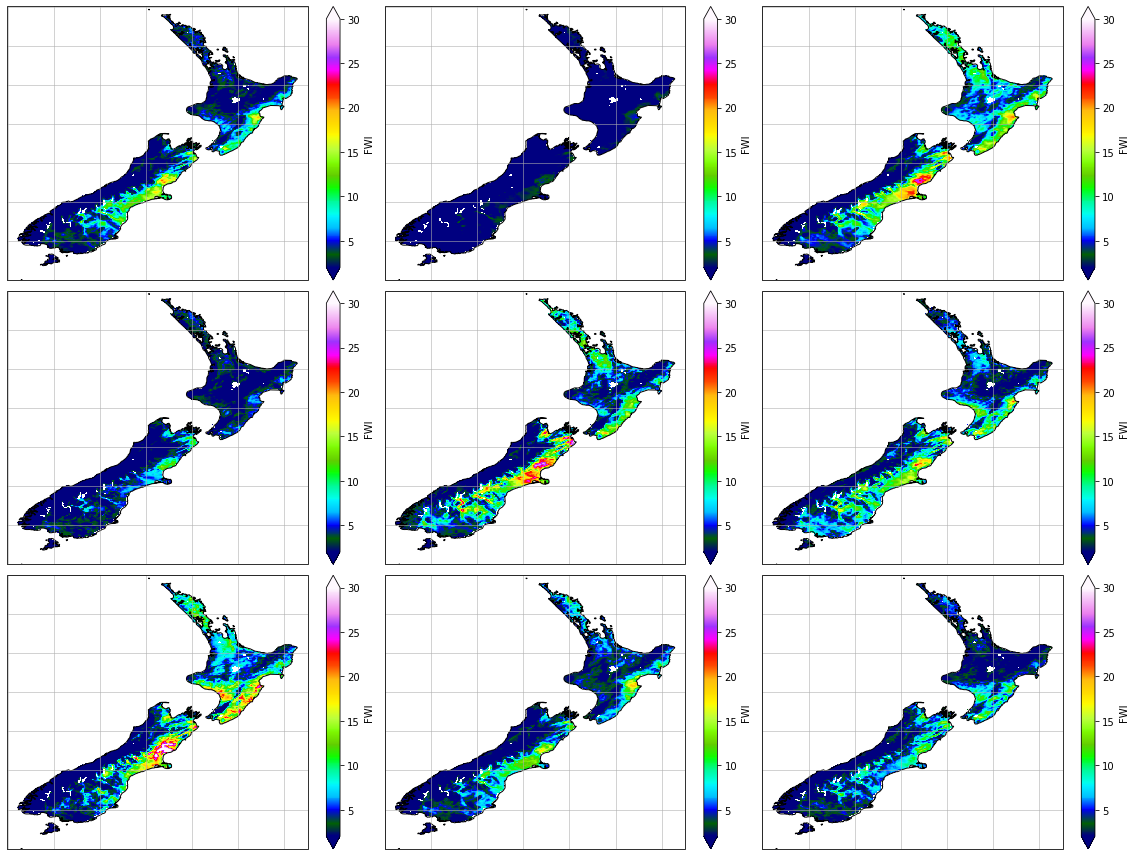

In [39]:
predsname = '1_preds_new'
somname = '1_som_new'
map_from_pickled_som(somname, predsname)

In [20]:
# som_dict = create_som_dict(FWI, predict_som)
# map_som(FWI, som_dict)

Doesn't look bad, some clear regional variation here. Will begin tuning by adjusting the learning rate to 0.8

In [15]:
%%time
som, predict_som = calc_som(3,3, ds_np_nonan,lr=0.8)

CPU times: user 9min 16s, sys: 2min 51s, total: 12min 7s
Wall time: 12min 11s


saved pickle
saved preds


(array([2143.,    8.,    4.,    8.,    0.,    8.,   11.,    4.,    3.,
           4.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

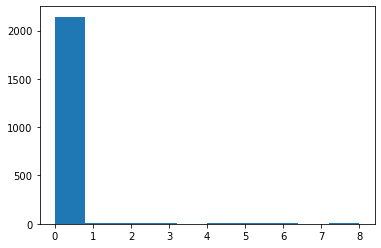

In [16]:
som_to_pickle('1_som_lr0dot8', som)
print('saved pickle')
preds_to_file('1_preds_lr0dot8.npy', predict_som)
print('saved preds')
plt.hist(predict_som)

One large cluster, lower the learning rate to 0.3

In [17]:
%%time
som, predict_som = calc_som(3,3, ds_np_nonan,lr=0.3)

CPU times: user 8min 59s, sys: 1min 33s, total: 10min 33s
Wall time: 10min 34s


saved pickle
saved preds


(array([  15.,    6.,    7., 1290.,    0.,  137.,  285.,   14.,    8.,
         431.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

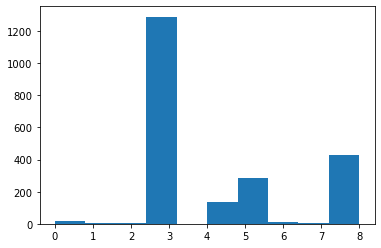

In [18]:
som_to_pickle('1_som_lr0dot3', som)
print('saved pickle')
preds_to_file('1_preds_lr0dot3.npy', predict_som)
print('saved preds')
plt.hist(predict_som)

Slightly more even distribution here than for 0.5. Will decrease the lr further to 0.1 

In [19]:
%%time
som, predict_som = calc_som(3,3, ds_np_nonan,lr=0.1)

CPU times: user 8min 41s, sys: 1min 34s, total: 10min 16s
Wall time: 10min 18s


saved pickle
saved preds


(array([  12., 1573.,   22.,   15.,    0.,  349.,   13.,    8.,  189.,
          12.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

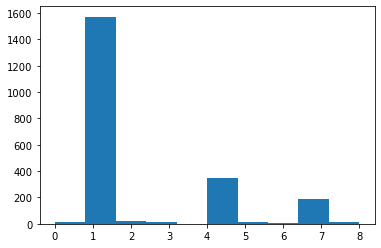

In [20]:
som_to_pickle('1_som_lr0dot1', som)
print('saved pickle')
preds_to_file('1_preds_lr0dot1.npy', predict_som)
print('saved preds')
plt.hist(predict_som)

Worse distribution than 0.3. Next will try m = 2

In [21]:
%%time
som, predict_som = calc_som(2,3, ds_np_nonan,lr=0.3)

CPU times: user 8min 17s, sys: 1min 11s, total: 9min 29s
Wall time: 9min 29s


saved pickle
saved preds


(array([  17.,    0., 2115.,    0.,   23.,    0.,   16.,    0.,   14.,
           8.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

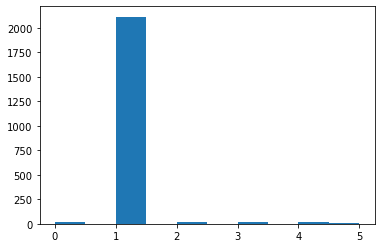

In [22]:
som_to_pickle('1_som_lr0dot3_m2', som)
print('saved pickle')
preds_to_file('1_preds_lr0dot3_m2.npy', predict_som)
print('saved preds')
plt.hist(predict_som)

Worse distribution again. Try m = 4, n = 4

In [23]:
%%time
som, predict_som = calc_som(4,4, ds_np_nonan,lr=0.3)

CPU times: user 9min 47s, sys: 2min 9s, total: 11min 56s
Wall time: 11min 57s


saved pickle
saved preds


(array([   9.,    3.,  271.,    8.,   12.,  104.,  447.,   15., 1309.,
          15.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

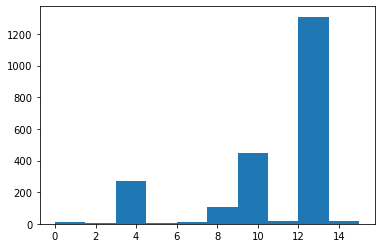

In [24]:
som_to_pickle('1_som_lr0dot3_m4n4', som)
print('saved pickle')
preds_to_file('1_preds_lr0dot3_m4n4.npy', predict_som)
print('saved preds')
plt.hist(predict_som)

m = 3, n = 3, lr = 0.3 seems to have the best distribution still. 

In [22]:
FWI = ds.FWI
time = ds.time
predict_som = load_preds('1_preds_lr0dot3.npy')
som = open_som_pickle('1_som_lr0dot3.pkl')

In [23]:

som_dict = {}
for i in range(0,9):
    mask = predict_som == i
    som_FWI = FWI[mask]
    mean_FWI = som_FWI.mean(dim="time")
    som_dict[str(i)]=mean_FWI.load()

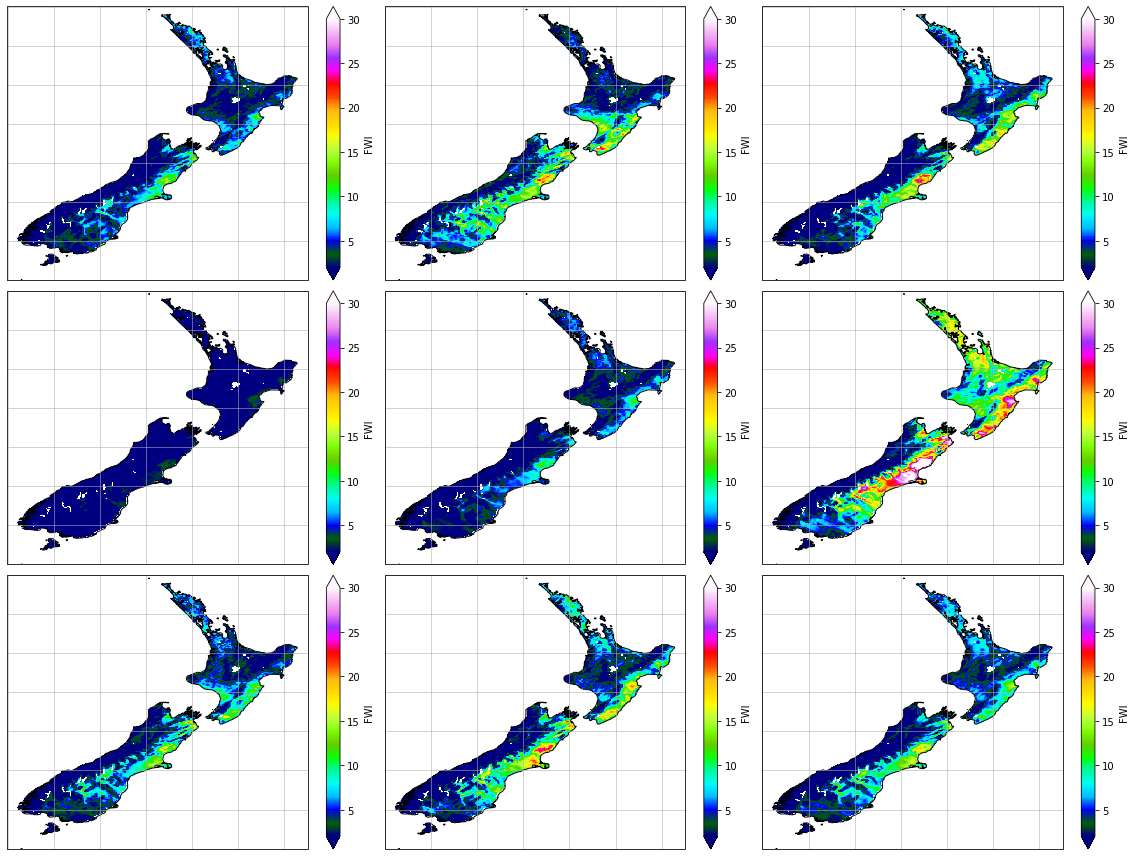

In [40]:
somname = '1_som_lr0dot3'
predsname = '1_preds_lr0dot3'
map_from_pickled_som(somname, predsname)

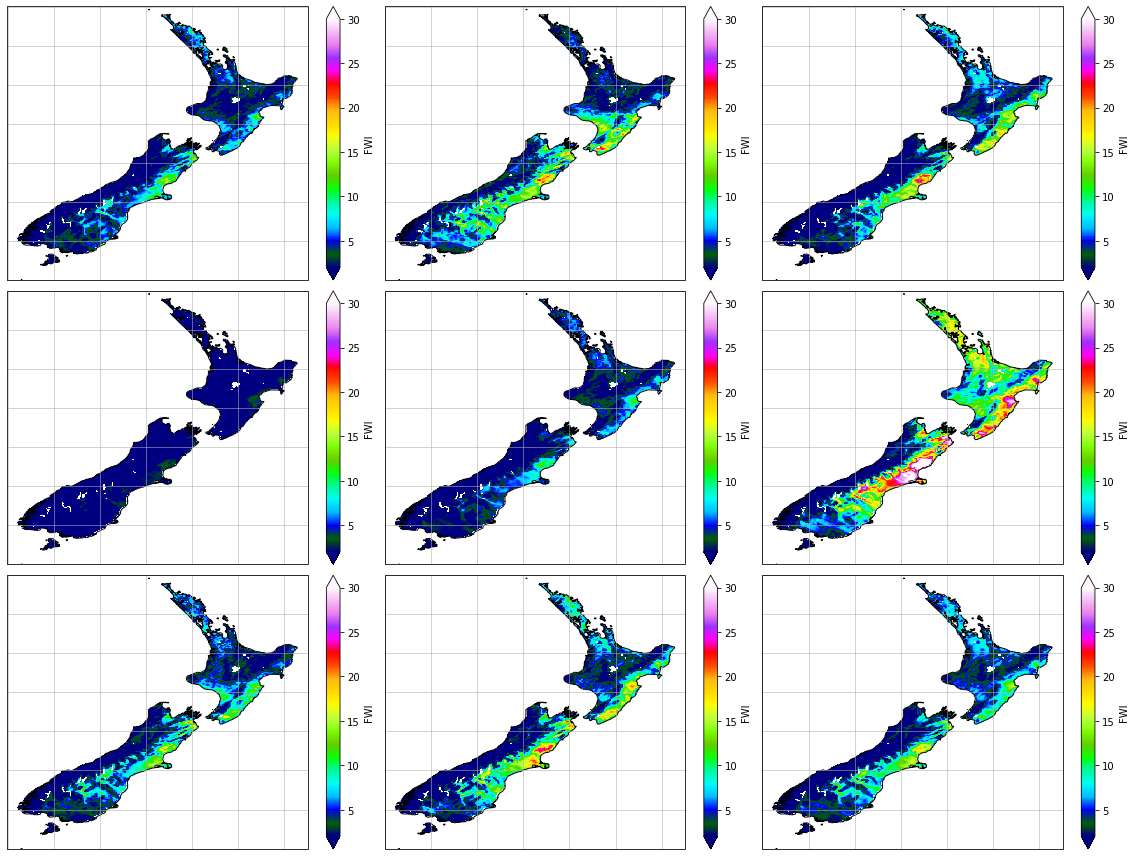

In [24]:
proj = FWI.salem.cartopy()
color_map ="Reds"
color_map ="gist_ncar"

fig = plt.figure(figsize=[16,12])
for i in range(0,9):
    ax = plt.subplot(3,3,i+1,projection=proj)
#     som_dict[str(i)].plot(cmap=color_map, transform=proj, vmin=0, vmax=80, extend="both")
    som_dict[str(i)].plot(cmap=color_map, transform=proj, vmin=2, vmax=30, extend="both")


    ax.coastlines('10m', linewidth=1)
    ax.set_aspect('auto')
    ax.set_extent(FWI.salem.grid.extent, crs=proj)
    ax.gridlines(alpha=0.7)
    plt.tight_layout()
#plt.savefig("som_4by4.pdf", dpi=60) 

There is a regional preference for high FWI in NZ, as can be seen above. The regions are most typified in the upper east coast of the South Island and the east coast of the North Island. Other areas with high FWI are the Northland / Auckland region, the top of the South Island.

## What can be driving the spatial variability?
  
The east coast of New Zealand is sheltered by the precipitation that comes from the Tasman Sea to the west.  
  
Let's compare the maps with NZ rainfall.

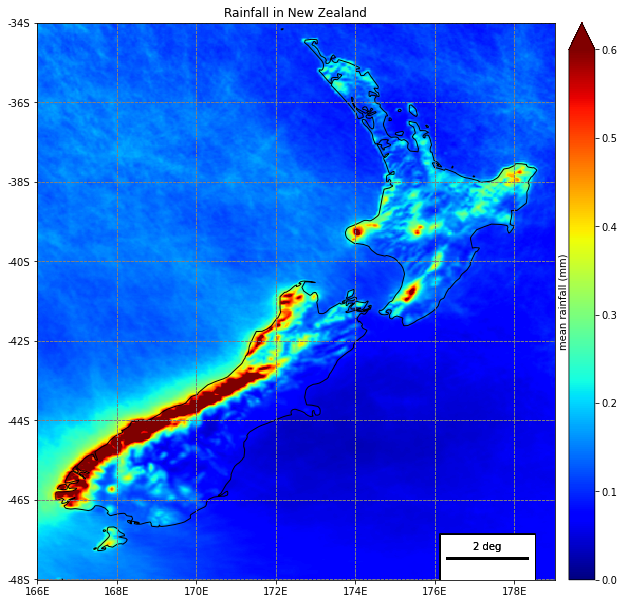

In [4]:



nz_rain = xr.open_mfdataset("/mnt/data/MetService_WRF/RAINNC_2020*").mean(dim="time")
# nz_rain = 
nz_rain.to_dataframe().max()



f, ax = plt.subplots(figsize=(10, 40))
smap = nz_rain.salem.get_map(countries=False)

# Add a scalebar
smap.set_scale_bar(location=(0.87, 0.04), add_bbox=True)


smap.plot(ax=ax)
plot_title = "Rainfall in New Zealand"#.format(threshold)
nz_rain.RAINNC.salem.quick_map(ax=ax, cmap='jet', vmin=0, vmax=0.6)
smap.visualize(ax=ax, addcbar=True, cbar_title="mm", title=plot_title)

# label for the colorbar
ax.yaxis.set_label_position("right")
ax.set_ylabel("mean rainfall (mm)")

plt.show()

We see substantially less rainfall on the east coast of NZ.   
I didn't mask the ocean areas as the map shows clearly the higher precipitation in the Tasman Sea to the east.  
Lets look at windspeed:

In [ ]:
from fwi_nz import wind_speed_from_component
years = list(range(2015, 2021))

ds_u = open_dataset(PATH, 'U', CHUNKS, years).isel(height=0).drop("height")
ds_v = open_dataset(PATH, 'V', CHUNKS, years).isel(height=0).drop("height")

ws = wind_speed_from_component(ds_u.U, ds_v.V).mean(dim='time')



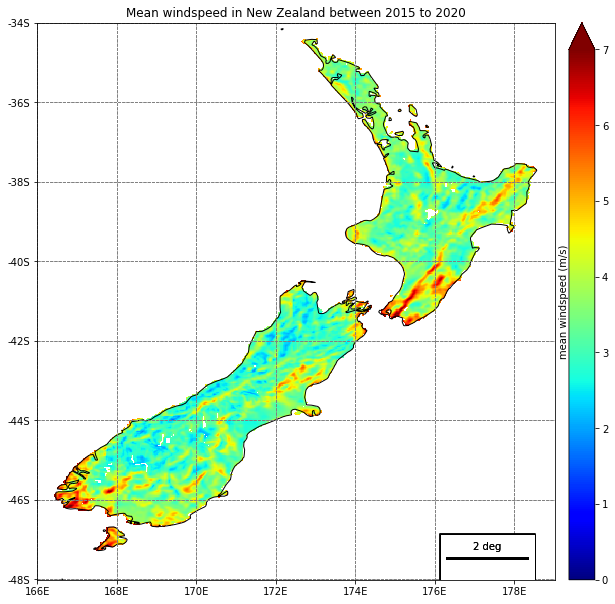

In [19]:
ws = mask_terrestrial_area(ws)

f, ax = plt.subplots(figsize=(10, 40))
smap = ws.salem.get_map(countries=False)

# Add a scalebar
smap.set_scale_bar(location=(0.87, 0.04), add_bbox=True)


smap.plot(ax=ax)
plot_title = "Mean windspeed in New Zealand between 2015 to 2020"#.format(threshold)
ws.salem.quick_map(ax=ax, cmap='jet', vmin=0, vmax=7)
smap.visualize(ax=ax, addcbar=True, cbar_title="mm", title=plot_title)

# label for the colorbar
ax.yaxis.set_label_position("right")
ax.set_ylabel("mean windspeed (m/s)")

plt.show()

High mean windspeed can be seen in the high FWI areas of the east coast of the North Island, the Canterbury plains, and the top of the South Island. 
High mean windspeed can also be seen in Southland and Stewart Island, but these are areas of heavy rainfall as seen in the mean rainfall map. 

In [22]:
# Temperature
ds_t = open_dataset(PATH, 'T', CHUNKS, years).isel(height=0).drop("height")

temp = ds_t.T - 273.15 # Convert K to C
temp = temp.mean(dim="time")


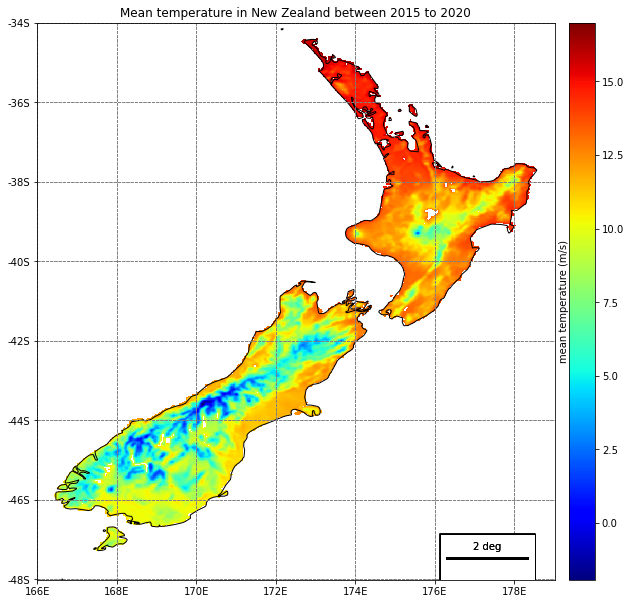

In [24]:
temp = mask_terrestrial_area(temp)

f, ax = plt.subplots(figsize=(10, 40))
smap = ws.salem.get_map(countries=False)

# Add a scalebar
smap.set_scale_bar(location=(0.87, 0.04), add_bbox=True)

smap.plot(ax=ax)
plot_title = "Mean temperature in New Zealand between 2015 to 2020"#.format(threshold)
temp.salem.quick_map(ax=ax, cmap='jet')#, vmin=0, vmax=0.6)
smap.visualize(ax=ax, addcbar=True, cbar_title="mm", title=plot_title)

# label for the colorbar
ax.yaxis.set_label_position("right")
ax.set_ylabel("mean temperature (m/s)")

plt.show()

High mean temperatures can be seen along the east coasts. These 3 maps explain most of the regional variability of FWI.  
However, at the top of the North Island, we have high temperatures and similar rainfall to the east coast of the north island.  So why isn't FWI high there?

In [26]:
ds_rh = open_dataset(PATH, 'RH', CHUNKS, years).isel(height=0).drop("height")
rh = ds_rh.RH.mean(dim="time")
rh = mask_terrestrial_area(rh)

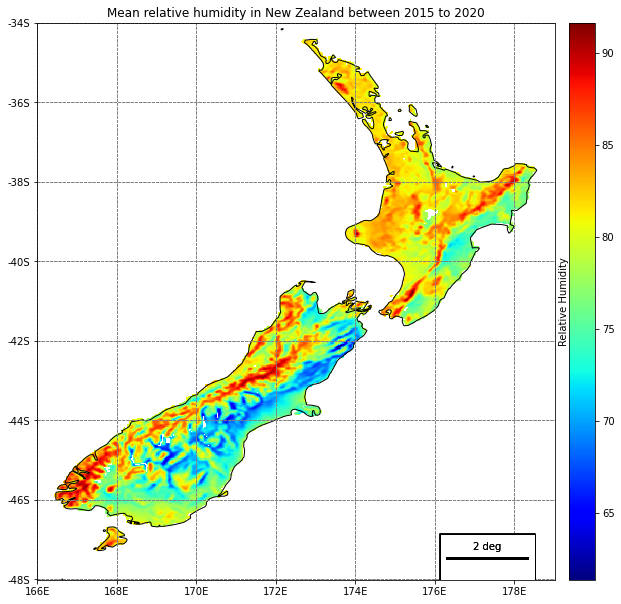

In [27]:
f, ax = plt.subplots(figsize=(10, 40))
smap = ws.salem.get_map(countries=False)

# Add a scalebar
smap.set_scale_bar(location=(0.87, 0.04), add_bbox=True)

smap.plot(ax=ax)
plot_title = "Mean relative humidity in New Zealand between 2015 to 2020"#.format(threshold)
rh.salem.quick_map(ax=ax, cmap='jet')#, vmin=0, vmax=0.6)
smap.visualize(ax=ax, addcbar=True, cbar_title="mm", title=plot_title)

# label for the colorbar
ax.yaxis.set_label_position("right")
ax.set_ylabel("Relative Humidity")

plt.show()

Here we can see high relative humidity at the top of the North Island. Which makes sense, as the top of the North Island is more tropical than the rest of the country.  
We see low relative humidity on the east coast. Low relative humidity is well correlated with the high FWI map, except for the near the Southern Alps where the temperatures are low. 

#### Exploring regions which exhibit more extreme fire weather during summer

Mask summer months (Dec Jan Feb)

In [44]:
def is_summer(month):
    return (((month >= 1) & (month <= 2)) | (month >= 12))

summer_data = ds.FWI.sel(time=is_summer(ds.FWI['time.month']))

In [45]:
summer_data

<xarray.DataArray 'FWI' (time: 543, lat: 508, lon: 472)>
dask.array<getitem, shape=(543, 508, 472), dtype=float64, chunksize=(24, 508, 472), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2014-12-31 2015-01-01 ... 2020-12-31
  * lat      (lat) float64 -48.0 -47.97 -47.94 -47.92 ... -34.06 -34.03 -34.01
  * lon      (lon) float64 166.0 166.0 166.1 166.1 ... 178.9 178.9 179.0 179.0

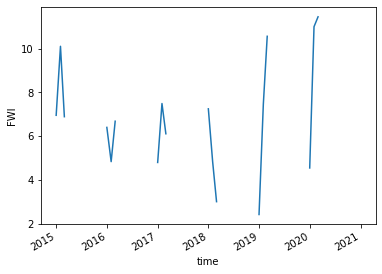

In [24]:
# rough and easy way to check we have 3 months of summer each year 
summer_data.groupby('time').mean(...).resample(time='1M').mean().plot()


In [11]:
# Convert the DataArray to numpy array 
FWI = summer_data
ds_np=xr.DataArray.to_numpy(FWI.load())
ds_np_nonan = np.nan_to_num(ds_np, nan = -9999)

In [12]:
%%time
som, predict_som = calc_som(2,3, ds_np_nonan,lr=0.3)

CPU times: user 8min, sys: 44.1 s, total: 8min 44s
Wall time: 8min 44s


In [22]:
# som_to_pickle('1_som_summer', som)
# print('saved pickle')
# preds_to_file('1_preds_summer.npy', predict_som)
# print('saved preds')


In [14]:
# Create som dictionary
som_dict = create_som_dict(FWI, preds)

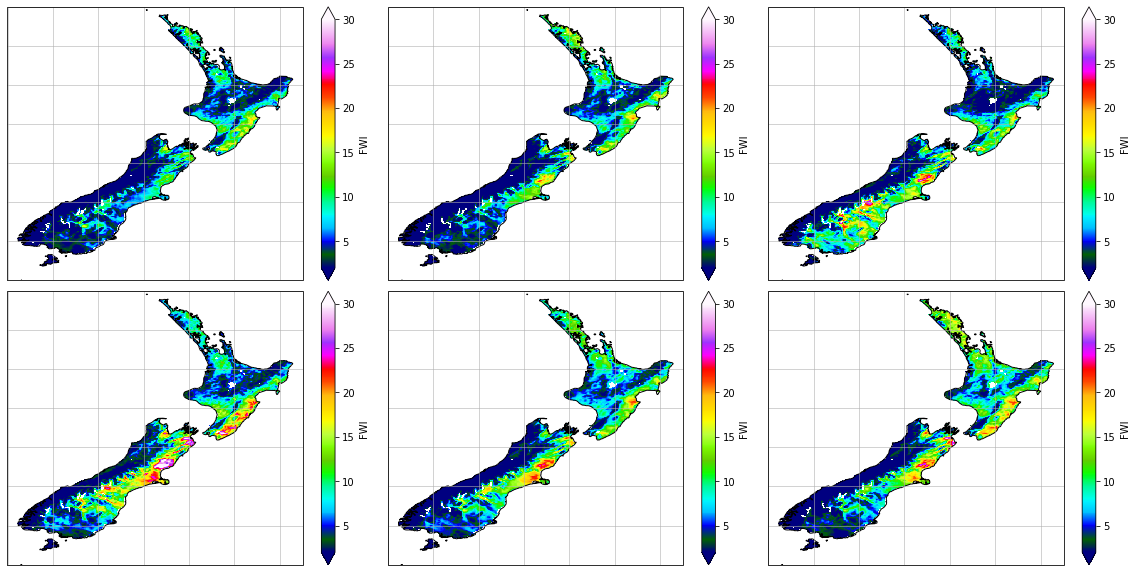

In [23]:
proj = FWI.salem.cartopy()
color_map ="gist_ncar"
fig = plt.figure(figsize=[16,12])
for i in range(0,6):
    ax = plt.subplot(3,3,i+1,projection=proj)
    som_dict[str(i)].plot(cmap=color_map, transform=proj, vmin=2, vmax=30, extend="both")

    ax.coastlines('10m', linewidth=1)
    ax.set_aspect('auto')
    ax.set_extent(FWI.salem.grid.extent, crs=proj)
    ax.gridlines(alpha=0.7)
    plt.tight_layout()
#plt.savefig("som_4by4.pdf", dpi=60) 

From the SOM's, it appears that the general regions that exhibit extreme FWI are the upper East coast of the South Island, the top of the South Island, and the east coast of the North Island 

### Regions
We can pull the regional masks from statsnz.
First lets have a look at the upper quantile for FWI summer data

In [48]:
data = summer_data
regions = geopandas.read_file("regional-council-2022-generalised.csv")


region count: 17


<xarray.DataArray 'FWI' (time: 543, lat: 115, lon: 171)>
dask.array<getitem, shape=(543, 115, 171), dtype=float64, chunksize=(24, 115, 171), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float64 -45.07 -45.05 -45.02 ... -41.98 -41.96 -41.93
  * lon          (lon) float64 169.6 169.6 169.6 169.6 ... 174.2 174.2 174.3
  * time         (time) datetime64[ns] 2014-12-31 2015-01-01 ... 2020-12-31
    spatial_ref  int64 0

In [80]:

def mask_terrestrial_area(data):
    # Create a mask based on moisture (the ocean very wet)
    smois_file = '/mnt/data/MetService_WRF/SMOIS_20000101000000.nc'
    chunks={"height":1,"time":100}
    smois = xr.open_dataset(smois_file,chunks=chunks)
    mask=(smois.SMOIS[0,1,...]<0.9)
    masked_data=data.where(mask)
    return masked_data

In [81]:
name = "REGC2022_V1_00_NAME"
means = {} # not a great name for this variable but I changed tactics
for i in range(len(regions)):
    data = summer_data
    geometry = regions["WKT"].loc[regions.index[i]]

    # load the shape string as a MultiPolygon shape
    poly = wkt.loads(geometry)
        # Convert to GeoPandas geoseries object
    geo = geopandas.GeoSeries(poly)

    # Set the crs of the data and the geoseries object
    geo.crs = "EPSG:4326"
    data = data.rio.write_crs("EPSG:4326")

    # Specify lon lat as the x y axes
    data = data.rio.set_spatial_dims("lon", "lat")

    # mask the data 
    clipped = data.rio.clip(geo.geometry.apply(mapping), "EPSG:4326")#, all_touched=True )
    clipped = mask_terrestrial_area(clipped)
    means[regions[name].loc[regions.index[i]]] = clipped#.mean().to_numpy()

In [82]:
quantiles = []
for key, item in means.items():
    if key != "Area Outside Region":
        q = item.chunk(dict(time=-1)).quantile(0.85).to_numpy()
        quantiles.append((key, q))
quantiles.sort(key=lambda x: -x[1])
quantiles

[("Hawke's Bay Region", array(21.66075569)),
 ('Canterbury Region', array(21.48122751)),
 ('Wellington Region', array(20.13095699)),
 ('Northland Region', array(20.06914871)),
 ('Marlborough Region', array(19.57730861)),
 ('Auckland Region', array(19.44294984)),
 ('Gisborne Region', array(16.56411452)),
 ('Waikato Region', array(15.69061485)),
 ('Manawatū-Whanganui Region', array(13.70687987)),
 ('Bay of Plenty Region', array(12.70236866)),
 ('Nelson Region', array(11.87802631)),
 ('Otago Region', array(11.69002897)),
 ('Taranaki Region', array(11.16606287)),
 ('Tasman Region', array(10.98248076)),
 ('Southland Region', array(6.35606564)),
 ('West Coast Region', array(3.3601356))]

And the regional mean

In [83]:
regional_means = []
for key, item in means.items():
    if key != "Area Outside Region":
        m = item.mean().to_numpy()
        regional_means.append((key, m))
regional_means.sort(key=lambda x: -x[1])
regional_means

[("Hawke's Bay Region", array(10.53639087)),
 ('Auckland Region', array(10.09980604)),
 ('Canterbury Region', array(10.09175854)),
 ('Northland Region', array(10.06285543)),
 ('Marlborough Region', array(9.38149699)),
 ('Wellington Region', array(9.27405505)),
 ('Gisborne Region', array(7.99372346)),
 ('Waikato Region', array(7.62372296)),
 ('Manawatū-Whanganui Region', array(6.43132501)),
 ('Bay of Plenty Region', array(5.84173418)),
 ('Nelson Region', array(5.71869236)),
 ('Otago Region', array(5.48134993)),
 ('Taranaki Region', array(5.31517121)),
 ('Tasman Region', array(5.04811469)),
 ('Southland Region', array(2.76234419)),
 ('West Coast Region', array(1.36479579))]

Mostly what we'd expect, although neither is a great way to find the extreme regions. High quantile works better than mean.
We see Hawkes Bay with a higher 85% quantile than Canterbury even though Canterbury show more extreme FWI. Canterbury has a large area including mountains which isn't helping.  
Might as well increase the quantile

In [93]:
quantiles = []
for key, item in means.items():
    if key != "Area Outside Region":
        q = item.chunk(dict(time=-1)).quantile(0.98).to_numpy()
        quantiles.append((key, float(q)))
quantiles.sort(key=lambda x: -x[1])
quantiles

[('Canterbury Region', 46.26595879765982),
 ("Hawke's Bay Region", 42.15298692363446),
 ('Marlborough Region', 40.62734011153991),
 ('Wellington Region', 38.15118648329691),
 ('Gisborne Region', 36.353756973612526),
 ('Northland Region', 33.4037728836379),
 ('Auckland Region', 32.409134585403336),
 ('Waikato Region', 28.380794944371086),
 ('Otago Region', 26.454993034224316),
 ('Manawatū-Whanganui Region', 25.874627902683933),
 ('Tasman Region', 25.417979736737237),
 ('Bay of Plenty Region', 24.86722298989425),
 ('Nelson Region', 21.563697858932684),
 ('Taranaki Region', 19.341363553688588),
 ('Southland Region', 17.295925806252235),
 ('West Coast Region', 9.028285082030905)]

Text(0, 0.5, 'FWI')

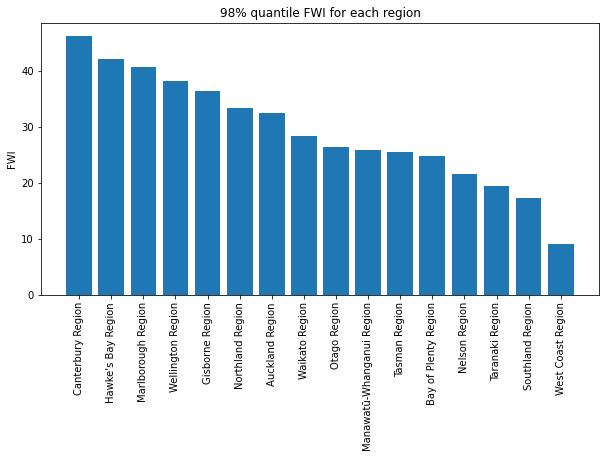

In [112]:
fig = plt.bar(list(q[0] for q in quantiles),list(q[1] for q in quantiles))
plt.title("98% quantile FWI for each region")
# plt.rcParams["figure.figsize"] = (10,5)
plt.xticks(rotation=90)
plt.ylabel("FWI")

Quite accurate, for the FWI data. Now put all this code into functions and see what it looks like on the SOMs

In [115]:
def clip_regions(data, regions):
    """ Use statsnz region polygons to mask each region. Returns dict of {region: clipped_data}
    """
    name = "REGC2022_V1_00_NAME"
    means = {} # not a great name for this variable but I changed tactics
    for i in range(len(regions)):
        geometry = regions["WKT"].loc[regions.index[i]]

        # load the shape string as a MultiPolygon shape
        poly = wkt.loads(geometry)
            # Convert to GeoPandas geoseries object
        geo = geopandas.GeoSeries(poly)

        # Set the crs of the data and the geoseries object
        geo.crs = "EPSG:4326"
        data = data.rio.write_crs("EPSG:4326")

        # Specify lon lat as the x y axes
        data = data.rio.set_spatial_dims("lon", "lat")

        # mask the data 
        clipped = data.rio.clip(geo.geometry.apply(mapping), "EPSG:4326")#, all_touched=True )
        clipped = mask_terrestrial_area(clipped)
        means[regions[name].loc[regions.index[i]]] = clipped#.mean().to_numpy()
    return means

In [118]:
def calculate_quantiles(means, q=0.98):
    """ takes dict of {region: data} and calculates the qth quantile
        returns sorted list of (region, quantile) tuples
    """
    quantiles = []
    for key, item in means.items():
        if key != "Area Outside Region":
#             q = item.chunk(dict(time=-1)).quantile(0.98).to_numpy()
            q = item.quantile(0.98).to_numpy()

            quantiles.append((key, float(q)))
    quantiles.sort(key=lambda x: -x[1])
    return quantiles

In [128]:
def bar_plotter(quantiles):
    """ single bar plot from sorted list of (region, quantile) tuples
    """
    fig = plt.bar(list(q[0] for q in quantiles),list(q[1] for q in quantiles))
    plt.title("98% quantile FWI SOM for each region")
    # plt.rcParams["figure.figsize"] = (10,5)
    plt.xticks(rotation=90)
    plt.ylabel("FWI")
def bar_plotter_ax(quantiles, ax):
    """ single bar plot from sorted list of (region, quantile) tuples
        this version can be put on axes
    """
    fig = ax.bar(list(q[0] for q in quantiles),list(q[1] for q in quantiles))




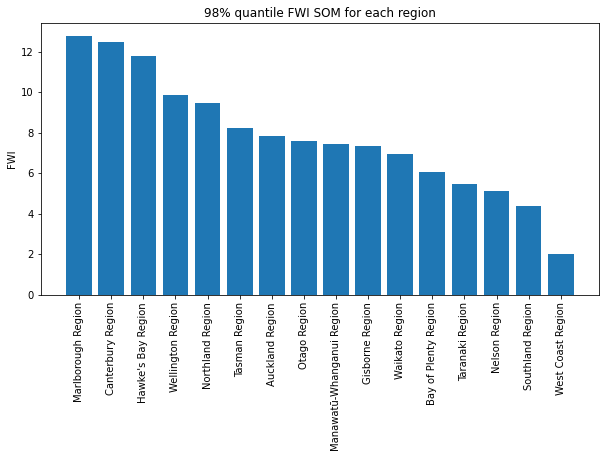

In [121]:
# Check it works for the som at the first index
clipped = clip_regions(som_dict['0'], regions)
quantiles = calculate_quantiles(clipped)
bar_plotter(quantiles)

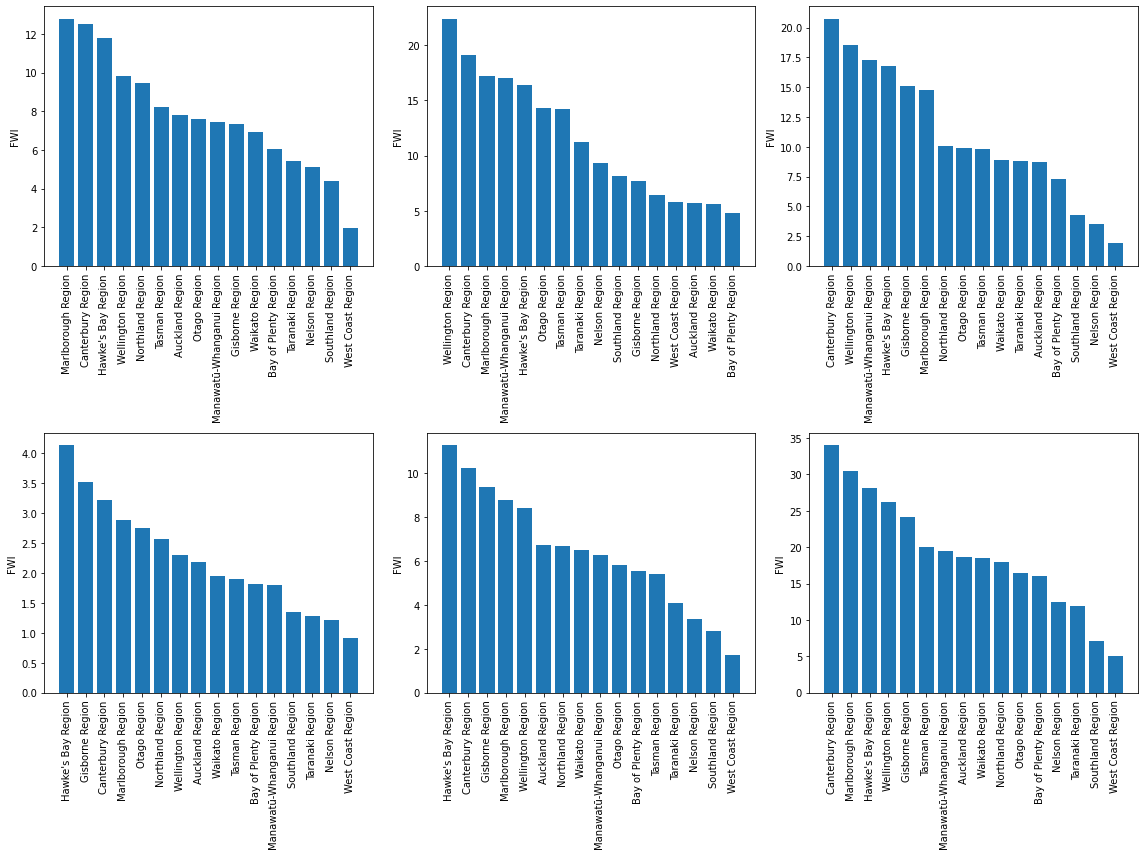

In [147]:
fig = plt.figure(figsize=[16,12])
# ax.title("98% quantile FWI SOM for each region")
plt.rcParams["figure.figsize"] = (10,5)
top_3 = set()  # Keep each top 3 region in a set
for i in range(0,6):
    clipped = clip_regions(som_dict[str(i)], regions)
    quantiles = calculate_quantiles(clipped)
    top_3.update(set(q[0] for q in quantiles[:3]))
    ax = plt.subplot(2,3, i+1)
#     som_dict[str(i)].plot(cmap=color_map, transform=proj, vmin=2, vmax=30, extend="both")
    bar_plotter(quantiles, ax)
#     ax.coastlines('10m', linewidth=1)
    plt.xticks(rotation=90)
    plt.ylabel("FWI")
    ax.set_aspect('auto')
#     ax.set_extent(FWI.salem.grid.extent, crs=proj)
#     ax.gridlines(alpha=0.7)
    plt.tight_layout()
    

We can see a similar distribution in all charts, with different regions appearing. Hawke's Bay and Canterbury have the highest twice each.  
Have re-plotted the SOMs below to make comparisons easier. 

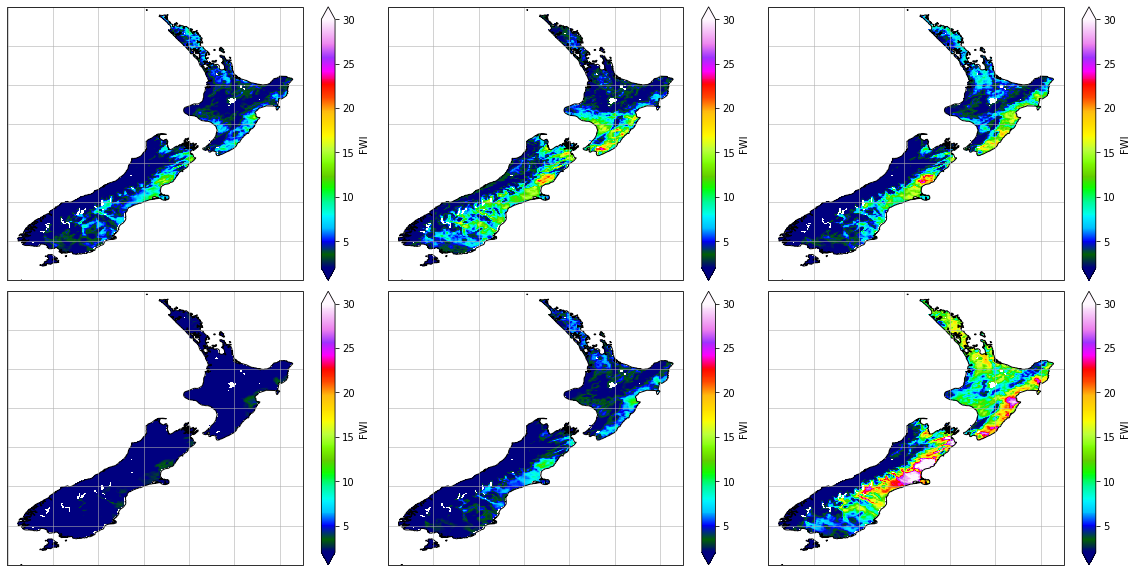

In [149]:
proj = FWI.salem.cartopy()
color_map ="gist_ncar"
fig = plt.figure(figsize=[16,12])
plt.title("SOM spatial information for FWI in New Zealand")
for i in range(0,6):
    ax = plt.subplot(3,3,i+1,projection=proj)
    som_dict[str(i)].plot(cmap=color_map, transform=proj, vmin=2, vmax=30, extend="both")

    ax.coastlines('10m', linewidth=1)
    ax.set_aspect('auto')
    ax.set_extent(FWI.salem.grid.extent, crs=proj)
    ax.gridlines(alpha=0.7)
    plt.tight_layout()
#plt.savefig("som_4by4.pdf", dpi=60) 

In [148]:
# Here we have each region that appeared at least once in the top three
top_3

{'Canterbury Region',
 'Gisborne Region',
 "Hawke's Bay Region",
 'Manawatū-Whanganui Region',
 'Marlborough Region',
 'Wellington Region'}

Canterbury, Hawke's Bay, Marlborough, Manawatū-Whanganui, Gisborne and Wellington can be said to be the regions that exhibit more extreme fire weather during the summers between the year 2015 to 2020.  
  
These areas are typically on the East Coast of NZ. In the South Island the FWI is more extreme on the upper East Coast. 

#### Repeating for the South Island  
Mask the South Island


In [10]:
def south_island(df):
    """
    created custom polygon file, "polygon.csv"
    to create a mask around south island region
    """
    all_regions = geopandas.read_file("polygon.csv")
    all_regions.crs = "EPSG:4326"
    geometry = all_regions["WKT"].loc[all_regions.index[0]] # if you add more polys just change the index here to the correct place
    canty_poly = shapely.wkt.loads(geometry)
    canty_poly2 = geopandas.GeoSeries(canty_poly)
    canty_poly2.crs = "EPSG:4326"
    df = df.rio.write_crs("EPSG:4326")
    df = df.rio.set_spatial_dims("lon", "lat")
    masked  = df.rio.clip(canty_poly2.geometry.apply(shapely.geometry.mapping), "EPSG:4326")
    return masked



Open 5 years of FWI data

In [46]:
# Load 5 years FWI
years = list(range(2015, 2021))
ds = open_dataset(FWI_PATH, 'FWI', CHUNKS, years)
ds = south_island(ds) # mask South Island
ds = mask_terrestrial_area(ds)
FWI, ds_np_nonan = fwi_to_np(ds)

Fit and predict the Self Organizing Map

In [47]:
%%time 
som, preds = calc_som(3,3, ds_np_nonan, lr=0.3, epochs=10)

CPU times: user 2min 33s, sys: 24.4 s, total: 2min 58s
Wall time: 2min 58s


In [48]:
# Save the SOM and predictions
preds_to_file('si_preds', preds)
som_to_pickle('si_som', som)

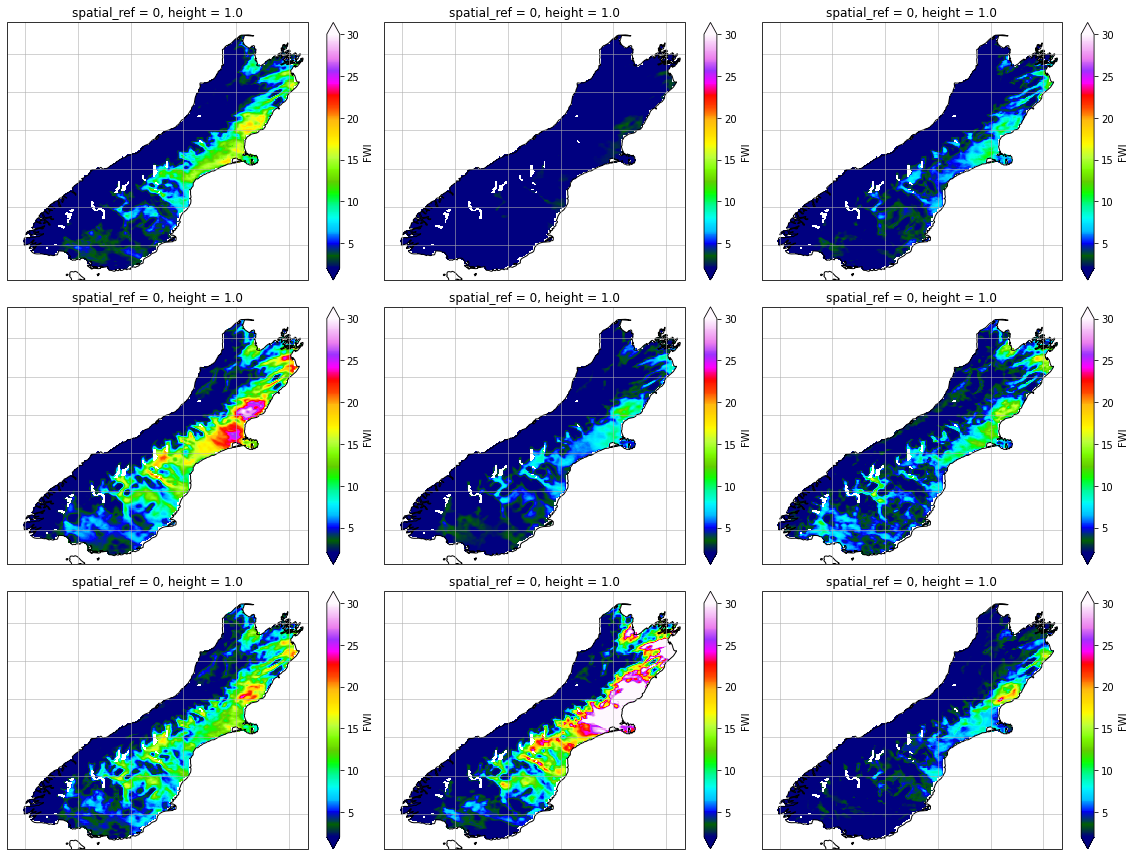

In [51]:
FWI = ds.FWI
som_dict = create_som_dict(FWI, preds)
map_som(FWI, som_dict)

In [11]:
# Thought it might be interesting to see what they look like if the map vmax is set to the max FWI

def map_som_vmax(FWI, som_dict,title):
    proj = FWI.salem.cartopy()
    color_map ="Reds"
    color_map ="gist_ncar"

    fig = plt.figure(figsize=[16,12])
    fig.title = title
    for i in range(0,9):
        ax = plt.subplot(3,3,i+1,projection=proj)
    #     som_dict[str(i)].plot(cmap=color_map, transform=proj, vmin=0, vmax=80, extend="both")
        to_map = som_dict[str(i)]
        vmax = to_map.max()
        to_map.plot(cmap=color_map, transform=proj, vmin=2, vmax=vmax, extend="both")

        
        ax.coastlines('10m', linewidth=1)
        ax.set_aspect('auto')
        ax.set_extent(FWI.salem.grid.extent, crs=proj)
        ax.gridlines(alpha=0.7)
        plt.tight_layout()
#plt.savefig("som_4by4.pdf", dpi=60) 

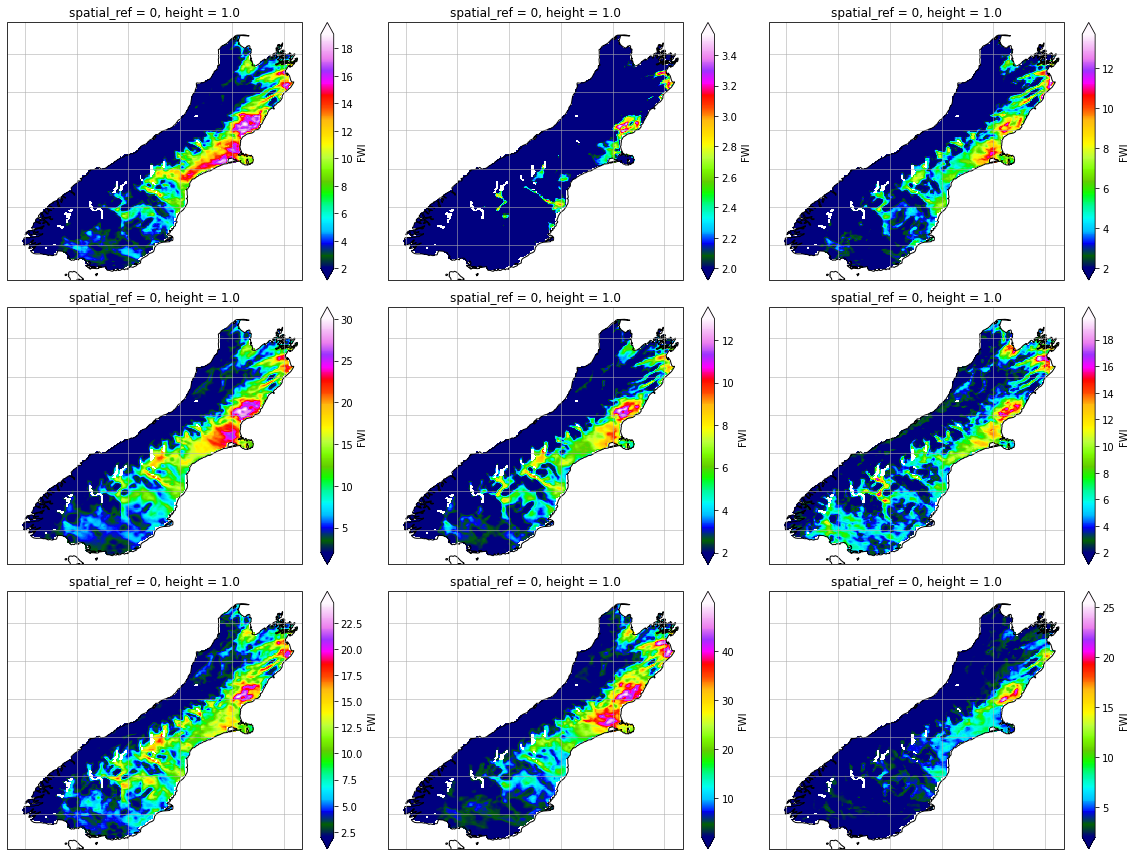

In [56]:
map_som_vmax(FWI, som_dict)

That's quite interesting and shows the spatial variation better. Central Otago features more prominently in the South Island maps. 

In [12]:
# A more general version
def variable_to_np(variable):
    """ Convert variable dataarray into numpy array without nan
        Works better as a function to garbage collect ds_np
    """
    
    ds_np_nonan = np.nan_to_num(xr.DataArray.to_numpy(variable.load()), nan = -9999)
    return ds_np_nonan

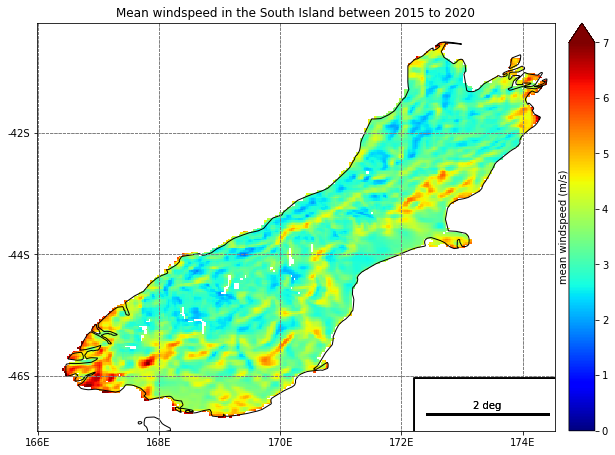

In [29]:
ws_si = south_island(ws)
f, ax = plt.subplots(figsize=(10, 40))
smap = ws_si.salem.get_map(countries=False)

# Add a scalebar
smap.set_scale_bar(location=(0.87, 0.04), add_bbox=True)


smap.plot(ax=ax)
plot_title = "Mean windspeed in the South Island between 2015 to 2020"#.format(threshold)
ws_si.salem.quick_map(ax=ax, cmap='jet', vmin=0, vmax=7)
smap.visualize(ax=ax, addcbar=True, cbar_title="mm", title=plot_title)

# label for the colorbar
ax.yaxis.set_label_position("right")
ax.set_ylabel("mean windspeed (m/s)")

plt.show()

Not a lot explained by the windspeed this time.  

For the temperature, will use the self organizing maps as well as the WRF data

In [12]:
# Loading 5 years kills the kernel, load just 2017
years = list(range(2015, 2021))
years = [2017]
# ds = open_dataset(PATH, 'T', CHUNKS, years)
ds = open_dataset(PATH, 'T', CHUNKS, years).isel(height=0).drop("height")

ds = south_island(ds) # mask South Island
ds = mask_terrestrial_area(ds)
# temp = temp.mean(dim="time")



In [15]:
temp = ds.T - 273.15 # Convert K to C
temp_no_nan = variable_to_np(temp)

In [16]:
temp_no_nan.shape

(8760, 244, 310)

In [17]:
%%time 
som, preds = calc_som(3,3, temp_no_nan, lr=0.3, epochs=10)

CPU times: user 2min 48s, sys: 33.5 s, total: 3min 22s
Wall time: 3min 22s


In [18]:
preds_to_file('si_preds_t', preds)
som_to_pickle('si_som_t', som)

In [19]:
som_dict = create_som_dict(temp, preds)

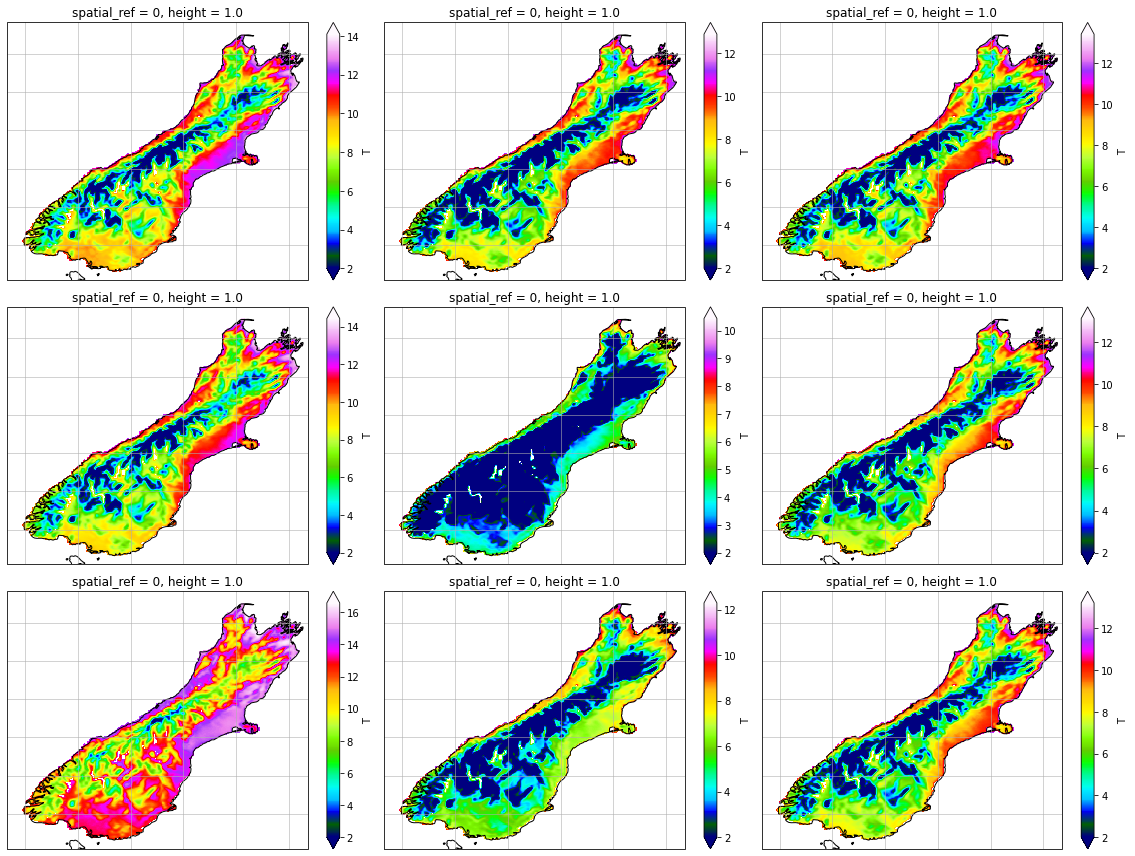

In [24]:
title = 'SOM of temperature in the South Island'
map_som_vmax(temp, som_dict, title)


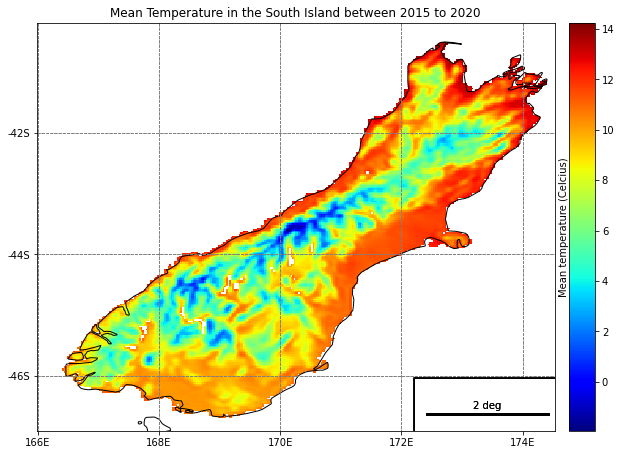

In [33]:
temps_si = south_island(temp)

f, ax = plt.subplots(figsize=(10, 40))
smap = temps_si.salem.get_map(countries=False)

# Add a scalebar
smap.set_scale_bar(location=(0.87, 0.04), add_bbox=True)


smap.plot(ax=ax)
plot_title = "Mean Temperature in the South Island between 2015 to 2020"#.format(threshold)
temps_si.salem.quick_map(ax=ax, cmap='jet')#, vmin=0, vmax=7)
smap.visualize(ax=ax, addcbar=True, cbar_title="mm", title=plot_title)

# label for the colorbar
ax.yaxis.set_label_position("right")
ax.set_ylabel("Mean temperature (Celcius)")

plt.show()

Central Otago temperature is more clear in the SOM than the mean, as there is high seasonal variation. 

In [13]:
# Loading 5 years kills the kernel
years = list(range(2015, 2021))
years = [2017]
ds = open_dataset(PATH, 'RH', CHUNKS, years).isel(height=0).drop("height")
ds = south_island(ds) # mask South Island
ds = mask_terrestrial_area(ds)



In [14]:
temp_no_nan = variable_to_np(ds.RH)

In [15]:
%%time 
som, preds = calc_som(3,3, temp_no_nan, lr=0.3, epochs=10)

CPU times: user 2min 49s, sys: 39.1 s, total: 3min 28s
Wall time: 3min 28s


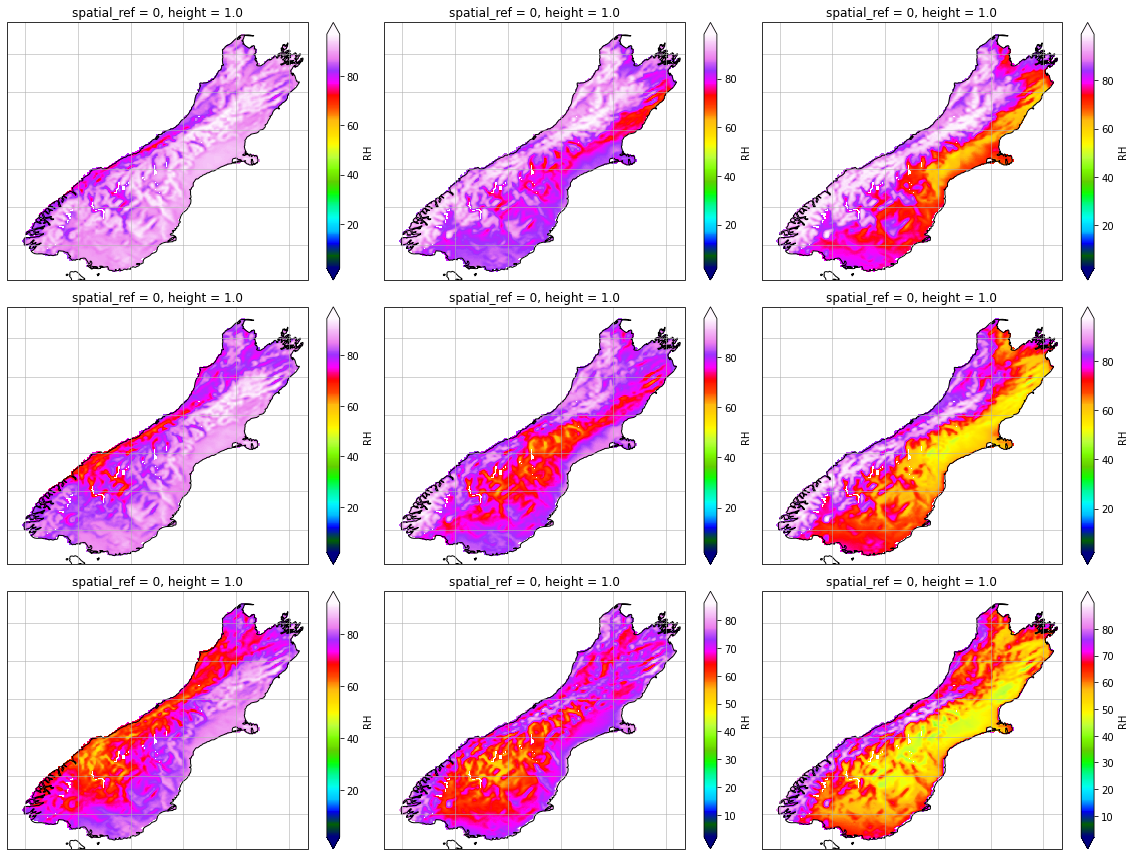

In [17]:
preds_to_file('si_preds_', preds)
som_to_pickle('si_som_t', som)

som_dict = create_som_dict(ds.RH, preds)

title = 'SOM of relative humidity in the South Island'
map_som_vmax(ds.RH, som_dict, title)

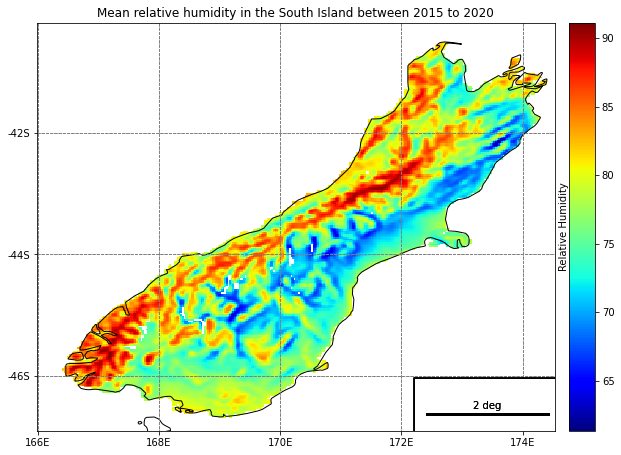

In [34]:
rh_si = south_island(rh)
f, ax = plt.subplots(figsize=(10, 40))
smap = rh_si.salem.get_map(countries=False)

# Add a scalebar
smap.set_scale_bar(location=(0.87, 0.04), add_bbox=True)


smap.plot(ax=ax)
plot_title = "Mean relative humidity in the South Island between 2015 to 2020"#.format(threshold)
rh_si.salem.quick_map(ax=ax, cmap='jet')#, vmin=0, vmax=7)
smap.visualize(ax=ax, addcbar=True, cbar_title="mm", title=plot_title)

# label for the colorbar
ax.yaxis.set_label_position("right")
ax.set_ylabel("Relative Humidity")

plt.show()

Very low relative humidity can be seen in Central Otago, the Canterbury plains and Marlborough

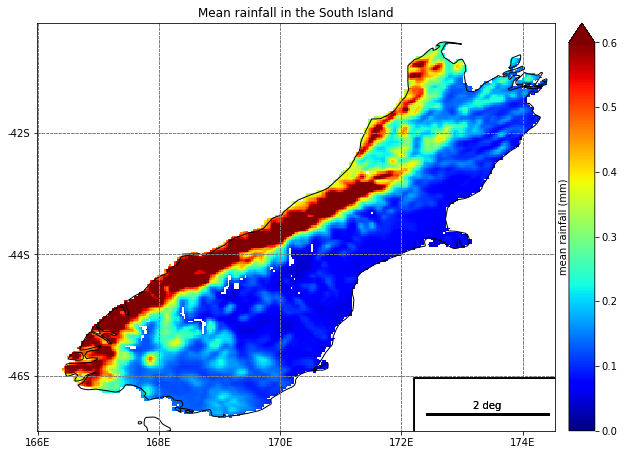

In [36]:
nz_rain = mask_terrestrial_area(nz_rain) # This time I will mask the ocean because the South Island polygon looks a bit rough
si_rain = south_island(nz_rain)
f, ax = plt.subplots(figsize=(10, 40))
smap = si_rain.salem.get_map(countries=False)

# Add a scalebar
smap.set_scale_bar(location=(0.87, 0.04), add_bbox=True)


smap.plot(ax=ax)
plot_title = "Mean rainfall in the South Island"#.format(threshold)
si_rain.RAINNC.salem.quick_map(ax=ax, cmap='jet', vmin=0, vmax=0.6)
smap.visualize(ax=ax, addcbar=True, cbar_title="mm", title=plot_title)

# label for the colorbar
ax.yaxis.set_label_position("right")
ax.set_ylabel("mean rainfall (mm)")

plt.show()

Low rainfall on the east coast of the South Island, and in Central Otago